In [1]:
import pandas as pd
import numpy as np

THE_MOST_IMPORTANT_K = 10 #Changed this, so i can use it in the split function as well, without any kind of refactoring.

In [2]:
names = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

In [3]:
categorical = set((
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'sex',
    'native-country',
    'race',
    'income',
))
df = pd.read_csv("adult.data", sep=", ", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
for name in categorical:
    df[name] = df[name].astype('category')

In [6]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [7]:
full_spans = get_spans(df, df.index)

In [44]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        # Commenting out the next 4 lines should make the world a better place, but who am i to know this for sure...
        # But it does not... Reality is 
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
        
        indexes = dfp.value_counts().index
        values = dfp.value_counts().values
        
        zipped = zip(indexes,values)
        sortedvals = np.array(sorted(zipped, key=lambda x: x[1]))
        sortedvalues = np.array(sortedvals[:,1],dtype=int)
        cumulated = np.cumsum(sortedvalues)
        
        bestindex = 0
        for i in range(len(cumulated)):
            if cumulated[i]>=THE_MOST_IMPORTANT_K and (cumulated[-1]-cumulated[i])>=THE_MOST_IMPORTANT_K and cumulated[i]<cumulated[-1]/2:
                bestindex = i
        if cumulated[bestindex+1]>=THE_MOST_IMPORTANT_K and (cumulated[-1]-cumulated[bestindex+1])>=THE_MOST_IMPORTANT_K:
            if np.abs(cumulated[-1]/2-cumulated[bestindex])>np.abs(cumulated[-1]/2-cumulated[bestindex+1]):
                bestindex+=1
        
        lv = set(sortedvals[:bestindex,0])
        rv = set(sortedvals[bestindex:,0])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        
        if len(dfl) < THE_MOST_IMPORTANT_K or len(dfr) < THE_MOST_IMPORTANT_K:
            median = dfp.mean() #Very clever hack, 200IQ code... xD
        
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        
        return (dfl, dfr)

In [45]:
def is_k_anonymous(df, partition, sensitive_column):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    #COMMENT OUT THE NEXT 4 LINES IF WE DO NOT WANT TO ENFORCE DIFFERENT SENSITIVE COLUMNS IN PARTITIONS
    
    #sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
    #for sensitive_value, count in sensitive_counts[sensitive_column].items():
        #if count == 0:
            #return False
    
    if len(partition) < THE_MOST_IMPORTANT_K:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        #Lil' faster
        if len(partition)<2*THE_MOST_IMPORTANT_K:
            finished_partitions.append(partition)
            continue
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [46]:
feature_columns = ['age', 'education-num','race','native-country','workclass']
sensitive_column = 'income'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [47]:
# we get the number of partitions that were created
len(finished_partitions)

1360

In [12]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [13]:
def build_anonymized_dataset_2(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        IsOkay = True
        #COMMENT OUT THE NEXT 3 LINES IF WE DO NOT WANT TO ENFORCE DIFFERENT SENSITIVE COLUMNS IN PARTITIONS
        #for sensitive_value, count in sensitive_counts[sensitive_column].items():
            #if count == 0:
                #IsOkay=False
        if IsOkay:
            for rowind in range(len(df.loc[partition])):
                currow = df.loc[partition].iloc[rowind,:].copy()
                for feature in feature_columns:
                    currow[feature]=grouped_columns[feature][0]
                rows.append(currow.copy())
    return pd.DataFrame(rows)

In [14]:
dfn2 = build_anonymized_dataset_2(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...


In [15]:
dfn2

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
2130,27.583333,"State-gov,Self-emp-inc",130620,11th,8.750000,Separated,Adm-clerical,Unmarried,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Female,0,0,40,"Taiwan,Dominican-Republic,United-States,German...",<=50K
3812,27.583333,"State-gov,Self-emp-inc",70447,HS-grad,8.750000,Married-civ-spouse,Protective-serv,Husband,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Male,0,0,40,"Taiwan,Dominican-Republic,United-States,German...",>50K
3909,27.583333,"State-gov,Self-emp-inc",139057,HS-grad,8.750000,Married-civ-spouse,Exec-managerial,Husband,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Male,0,0,84,"Taiwan,Dominican-Republic,United-States,German...",>50K
4457,27.583333,"State-gov,Self-emp-inc",93589,HS-grad,8.750000,Divorced,Protective-serv,Own-child,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Male,0,0,40,"Taiwan,Dominican-Republic,United-States,German...",<=50K
9128,27.583333,"State-gov,Self-emp-inc",119422,HS-grad,8.750000,Never-married,Other-service,Unmarried,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Female,0,0,30,"Taiwan,Dominican-Republic,United-States,German...",<=50K
9678,27.583333,"State-gov,Self-emp-inc",190450,HS-grad,8.750000,Married-civ-spouse,Sales,Husband,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Male,0,0,40,"Taiwan,Dominican-Republic,United-States,German...",<=50K
20091,27.583333,"State-gov,Self-emp-inc",23740,HS-grad,8.750000,Never-married,Transport-moving,Not-in-family,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Male,0,0,38,"Taiwan,Dominican-Republic,United-States,German...",>50K
23564,27.583333,"State-gov,Self-emp-inc",289886,HS-grad,8.750000,Never-married,Other-service,Unmarried,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Male,0,0,40,"Taiwan,Dominican-Republic,United-States,German...",<=50K
24202,27.583333,"State-gov,Self-emp-inc",67053,HS-grad,8.750000,Never-married,Other-service,Not-in-family,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Male,0,0,40,"Taiwan,Dominican-Republic,United-States,German...",<=50K
24312,27.583333,"State-gov,Self-emp-inc",147280,HS-grad,8.750000,Never-married,Other-service,Other-relative,"Asian-Pac-Islander,Amer-Indian-Eskimo,Other",Male,0,0,40,"Taiwan,Dominican-Republic,United-States,German...",<=50K


(array([1.232e+03, 2.500e+01, 2.200e+01, 3.100e+01, 2.000e+01, 6.000e+00,
        1.400e+01, 8.000e+00, 1.000e+00, 1.000e+00]),
 array([ 10. ,  34.6,  59.2,  83.8, 108.4, 133. , 157.6, 182.2, 206.8,
        231.4, 256. ]),
 <a list of 10 Patch objects>)

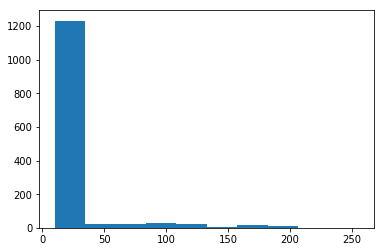

In [52]:
import matplotlib.pyplot as plt
import numpy as np

sizes = np.zeros(len(finished_partitions))
for i in range(len(finished_partitions)):
    sizes[i]=finished_partitions[i].shape[0]

plt.hist(sizes)